In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle as pkl
import numpy.random as nrand
import scipy.stats as stats

In [3]:
# Set matplotlib style
rcParams_dict = {
    'font.size': 15,
    'pdf.fonttype':42,
    'font.family':'Arial',
    'mathtext.fontset':'custom',
    'mathtext.default': 'regular',
    'mathtext.it': 'Arial:italic',
    'mathtext.it': 'Arial:italic',
}
mpl.rcParams.update(rcParams_dict)

In [ ]:
"""
Visualize allele-frequency (AF) trajectories and fitness dynamics from SLiM outputs.

Figures (Fig. 4a–c)
    Draw AF time series for each model, colored by average |s|:
    - blue: ~neutral (mean |s| <= 0)
    - black: weakly selected (0 < mean |s| < 0.005)
    - red: strongly non-neutral (mean |s| >= 0.005)

Inputs
------
- ./data/Simulation_log/<MODEL>.pkl
    Pickled dict mapping mutation ID -> {'AF': list, 'SG': int, 'EG': int, 's': list}.
"""

In [5]:
# Uncomment if want to regenerate the .pkl file.
# Load 20 simulation snapshots and scans through to tracks each mutation’s allele frequency and 
# selection coefficient over time, and builds a dictionary of mutation trajectories. 

# model = 'Adaptrack_env20' # Choose simulation model to process. 
#                             # Options: "Adaptrack_standard", "Adaptrack_env20", "Neutral"

# AF_dict = {}

# for N_gen in range(80000, 110001, 10):
#     print(N_gen, flush=True, end='\r')
    
#     tmp_df = pd.read_table(
#         f'./data/Simulation_log/{model}_AF_dynamics/{model}_{N_gen}.txt',  
#         header = None,
#         sep = '\s+'
#     )

#     tmp_df = tmp_df[[4, 7, 10, 11]].rename({4:'ID', 7:'s', 10:'SG', 11:'AF'}, axis=1)
    
#     for i, row in tmp_df.iterrows():
#         ID = row['ID']
#         if (ID in AF_dict) and (row['AF'] < 20000):
#             AF_dict[ID]['AF'].append(row['AF'])
#             AF_dict[ID]['s'].append(row['s'])
#             AF_dict[ID]['EG'] = N_gen
#         elif row['AF'] < 20000:
#             AF_dict[ID]={'AF':[row['AF']], 'SG':row['SG'], 'EG':N_gen, 's':[row['s']]}

# with open(f'./data/Simulation_log/{model}_AF_dynamics.pkl', 'wb') as f:
#     pkl.dump(AF_dict, f)

In [2]:
# model_dict structure:
#   model_name -> [random_seed, ids of strongly non-neutral mutations, (loaded later) AF_dict]

model_dict = {
    'Neutral_AF_dynamics': [13, []], # for Neutral model (Fig. 4a)
    'Adaptrack_standard_AF_dynamics': [22, [27842930.0,31294446.0]], # for Adaptrack standard model (Fig. 3b)
    'Adaptrack_env20_AF_dynamics': [30, [26427231.0,33683783.0]] # for Adaptrack_env20 model (Fig. 4c)
}
model_list = list(model_dict.keys())

# Load AF_dict
for i, model in enumerate(model_list):
    with open(f'./data/Simulation_log/{model}.pkl','rb') as f:
        AF_dict = pkl.load(f)
    model_dict[model].append(AF_dict)

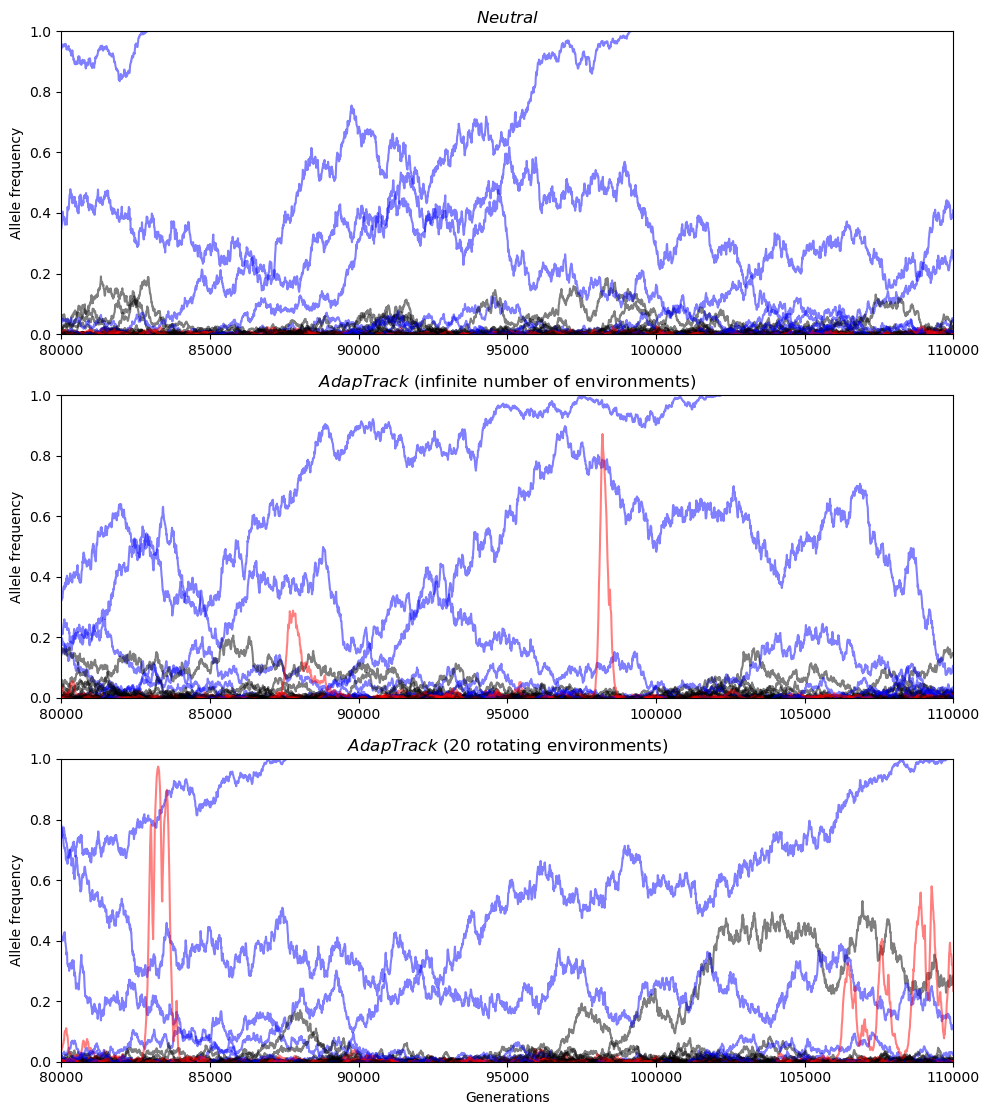

In [3]:
title_list = [
    '$\mathit{Neutral}$',
    '$\mathit{AdapTrack}$ (infinite number of environments)',
    '$\mathit{AdapTrack}$ (20 rotating environments)'
]

# Fig. 3A–C: AF trajectories
fig,axes = plt.subplots(3, 1, figsize=[10, 11.25], facecolor='w')

for i, model in enumerate(model_list):
    ax = axes[i]    
    seed, add_ids, AF_dict = model_dict[model]
    id_list = list(AF_dict.keys())
    
    # Randomly sample a large subset of mutation IDs and force-include notable ones
    nrand.seed(seed)
    id_sub_list = nrand.choice(id_list,50000,replace=False)
    id_sub_list = np.append(id_sub_list, add_ids)
    
    for _id in id_sub_list:
        item = AF_dict[_id]
        
        # Skip very short lifetimes to reduce visual clutter
        if item['EG'] - item['SG'] < 200:
            continue

        # Color by average absolute selection coefficient
        if np.abs(item['s']).mean() <= 0:
            c = 'b'; a=0.5            # ~neutral
        elif np.abs(item['s']).mean() < 0.005:
            c = 'k'; a = 0.5            # weakly non-neutral
        else:
            c = 'r'; a=0.5;            # strongly non-neutral

        # X-axis in generations, Y-axis is AF (counts up to 20000)
        ax.plot(
            range(max(80000,int(item['SG'])),int(item['EG'])+1,10),item['AF'],
            color = c,
            alpha = a
        )
    
    ax.set_ylim(0,20000)
    ax.set_xlim(80000,110000)
    ax.set_yticks(np.linspace(0,20000,6))
    ax.set_yticklabels(np.linspace(0,10,6)/10) # convert counts to frequency (0..1)
    ax.set_ylabel('Allele frequency')
    if i == len(model_list) - 1:
        ax.set_xlabel('Generations')
    ax.set_title(title_list[i])
plt.tight_layout()

#plt.savefig('./Figures/Fig4abc.pdf')

In [ ]:
"""
Visualize fitness dynamics from SLiM outputs.

Figures (Fig. 4d–f)
    Mean fitness over time for Neutral, AdapTrack (infinite environments), and
    AdapTrack (20 rotating environments). Grey shading marks alternating
    environment segments for the AdapTrack models.

Inputs
------
- ./data/Simulation_log/sim_summary_<version>.txt
    CSV with at least columns: 'generation', 'Mean_fitness', and for AdapTrack
    variants also 'env_idx'.
"""

In [7]:
# Load simulatoin summary files
sim_df_dict = {} 
for version in ['Neutral','Adaptrack_standard','Adaptrack_env20']:
    sim_df_dict[version] = pd.read_csv(f'./data/Simulation_log/sim_summary_{version}.txt')

# Detect environment switches via changes in env_idx
env_change_dict = {}
for version in ['Adaptrack_standard','Adaptrack_env20']:
    env_change_list = []
    p_env = -1 # track the "previous" environment index
    for i,row in sim_df_dict[version].iterrows():
        # When env_idx changes, record the generation where it happened
        if row['env_idx'] != p_env:
            env_change_list.append(row['generation'])
            p_env = row['env_idx']

    # Store list of environment change points for this model
    env_change_dict[version] = env_change_list

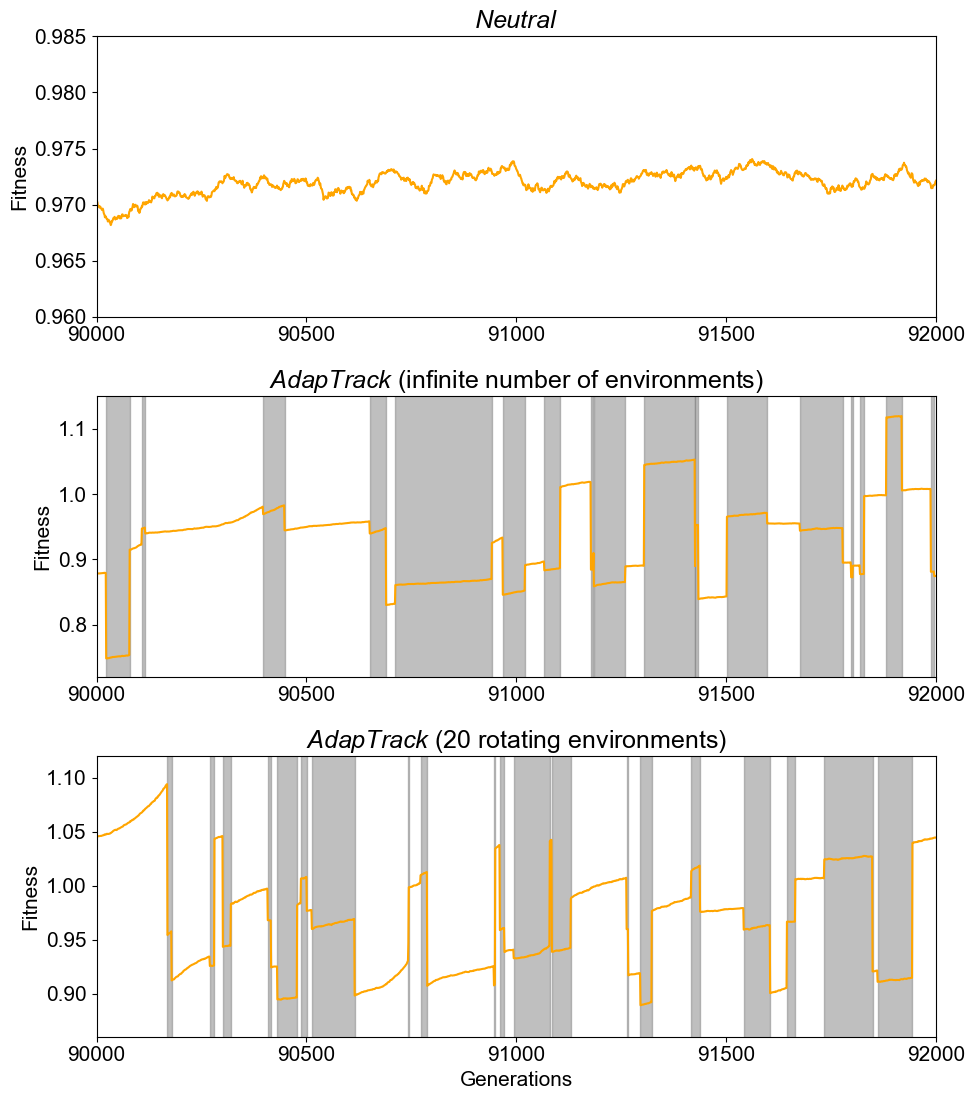

In [11]:
# Plot fitness trejactories for different models

color_list = ['orange', 'orange', 'orange']
title_list = [
    '$\mathit{Neutral}$',
    '$\mathit{AdapTrack}$ (infinite number of environments)',
    '$\mathit{AdapTrack}$ (20 rotating environments)'
]

fig,axes = plt.subplots(3,1,figsize=[10,11.25],facecolor='w')
for i, version in enumerate(['Neutral', 'Adaptrack_standard', 'Adaptrack_env20']):
    ax = axes[i]
    ax.plot(sim_df_dict[version]['Mean_fitness'],color=color_list[i])
    
    # Shade alternating environment blocks for AdapTrack models
    if version != 'Neutral':
        Gen_pointer = -1 # temporary "start of block" pointer

        # Walk through environment change generations
        for Gen_idx in env_change_dict[version]:
            if Gen_idx > 90000:
                if Gen_pointer == -1:
                    # First change in a pair -> mark block start
                    Gen_pointer = Gen_idx
                else:
                    # Second change -> fill shaded region between start and end
                    ax.fill_between([Gen_pointer-80000,Gen_idx-80000], 0, 1.5, alpha=0.5,color='grey')
                    Gen_pointer = -1
            elif Gen_idx > 92000:
                break
                
    # Show only the last ~2k steps (90k–92k generations)
    ax.set_xlim(10000,12000)
    ax.set_xticks(range(10000,12001,500))
    ax.set_xticklabels(range(90000,92001,500))

    # Formatting
    if version == 'Neutral':
        ax.set_ylim(0.96,0.985)
    elif version == 'Adaptrack_standard':
        ax.set_ylim(0.72,1.15)
    elif version == 'Adaptrack_env20':
        ax.set_ylim(0.86,1.12)
    ax.set_ylabel('Fitness')
    if i == 2:
        ax.set_xlabel('Generations')
    ax.set_title(title_list[i])
    
plt.tight_layout()
#plt.savefig('./Figures/Fig4def.pdf')